## 1. Load Dependencies & Dataset:

In [22]:
# Import Modules
import json
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequentia
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

In [ ]:
# all-images file should be uploaded to the same file
imageNames = glob.glob("all-images/*")

dataset = []
labels = []

for i, imName in enumerate(imageNames):

    # Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break

#Convert data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

#convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save("", data)
np.save("", labels)

In [2]:
# load the saved data
data = np.load('data.npy')
labels = np.load('labels.npy')

## 2. Data Preparation

In [ ]:
def preprocess_data(data, labels):
    # First, split the data into training (80%) and temporary data (20%)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
    
    # Then, split the temporary data into validation (50%) and final training (50%)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42, stratify=y_train_temp)
    
    y_train = pd.get_dummies(pd.DataFrame(y_train, columns=['labels'])).to_numpy(dtype='float32')
    y_test = pd.get_dummies(pd.DataFrame(y_test, columns=['labels'])).to_numpy(dtype='float32')
    y_val = pd.get_dummies(pd.DataFrame(y_val, columns=['labels'])).to_numpy(dtype='float32')
    
    X_train = (X_train.astype('float32') / 255.0)
    X_val = (X_val.astype('float32') / 255.0)
    X_test = (X_test.astype('float32') / 255.0)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(data, labels)

## 3. Create Baseline Model

In [12]:
baseline_model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding = 'same', input_shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu', padding = 'same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding = 'same'),
    Conv2D(32, (3,3), activation='relu', padding = 'same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

baseline_model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-11-13 22:07:13.437447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-13 22:07:13.438497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                    

In [13]:
baseline_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = baseline_model.evaluate(X_test, y_test)

Epoch 1/10


2023-11-13 22:08:59.904926: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-13 22:09:00.267483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 1.1634 - accuracy: 0.4604

2023-11-13 22:09:19.505146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 25s 246ms/step - loss: 1.1634 - accuracy: 0.4604 - val_loss: 0.9508 - val_accuracy: 0.5978
Epoch 2/10
87/87 [==============================] - 20s 226ms/step - loss: 0.7874 - accuracy: 0.6680 - val_loss: 0.7628 - val_accuracy: 0.6640
Epoch 3/10
87/87 [==============================] - 20s 228ms/step - loss: 0.6609 - accuracy: 0.7136 - val_loss: 0.7392 - val_accuracy: 0.6864
Epoch 4/10
87/87 [==============================] - 27s 309ms/step - loss: 0.6430 - accuracy: 0.7219 - val_loss: 0.6842 - val_accuracy: 0.7042
Epoch 5/10
87/87 [==============================] - 29s 333ms/step - loss: 0.5789 - accuracy: 0.7421 - val_loss: 0.6446 - val_accuracy: 0.7161
Epoch 6/10
87/87 [==============================] - 26s 305ms/step - loss: 0.5297 - accuracy: 0.7693 - val_loss: 0.7032 - val_accuracy: 0.7204
Epoch 7/10
87/87 [==============================] - 28s 322ms/step - loss: 0.4744 - accuracy: 0.7801 - val_loss: 0.7301 - val_accuracy: 0.6911
Epoch 8/10

In [14]:
y_pred = baseline_model.predict(X_test)

 1/44 [..............................] - ETA: 8s

2023-11-13 22:13:37.428730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 4s 84ms/step


## 4. Analyze the performance of the baseline model

In [20]:
# Plot model accuracy/loss 
def plot_training_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

    # Plot accuracy on the left subplot
    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    axes[0].plot(range(1, len(acc_history) + 1), acc_history)
    axes[0].plot(range(1, len(val_acc_history) + 1), val_acc_history)
    axes[0].set_title('Accuracy of Model')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(['training_accuracy', 'validation_accuracy'])

    # Plot loss on the right subplot
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    axes[1].plot(range(1, len(loss_history) + 1), loss_history)
    axes[1].plot(range(1, len(val_loss_history) + 1), val_loss_history)
    axes[1].set_title('Loss of Model')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend(['training_loss', 'validation_loss'])

    # Show the plots
    plt.tight_layout()
    plt.show()

# Performance meausres
def metrics (y_test, y_pred):

    y_true_indices = np.argmax(y_test, axis=1)  
    predicted_indices = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_true_indices, predicted_indices, average='macro')  
    precision = precision_score(y_true_indices, predicted_indices, average='macro')
    recall = recall_score(y_true_indices, predicted_indices, average='macro')


    metrics_dict = {
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall]
    }

    metrics_df = pd.DataFrame(metrics_dict, index=['Value'])

    return metrics_df

# Plot ROC/AUC curve
def plot_roc_curves(y_test, y_pred, target_names):

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    # Store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    for i in range(len(target_names)):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(len(target_names)):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # Linear interpolation

    # Average it and compute AUC
    mean_tpr /= len(target_names)

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(7, 7))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "peru"])
    for class_id, color in zip(range(len(target_names)), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_pred[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, y_test, class_labels):
    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

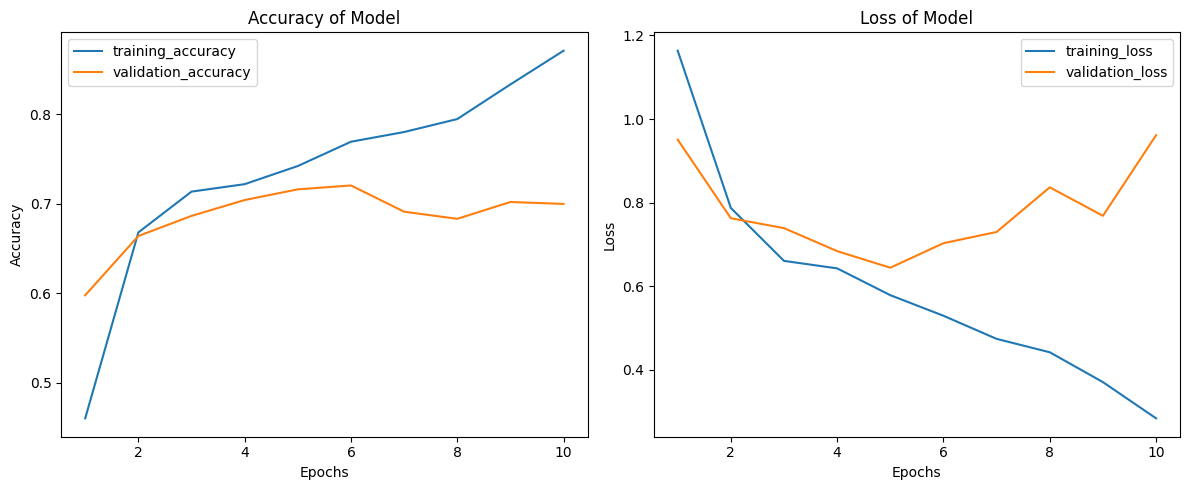

In [18]:
plot_training_history(history)

In [19]:
# Print the performance measures
metrics(y_test, y_pred)

,F1-Score,Precision,Recall
Value,0.605906,0.616337,0.600252


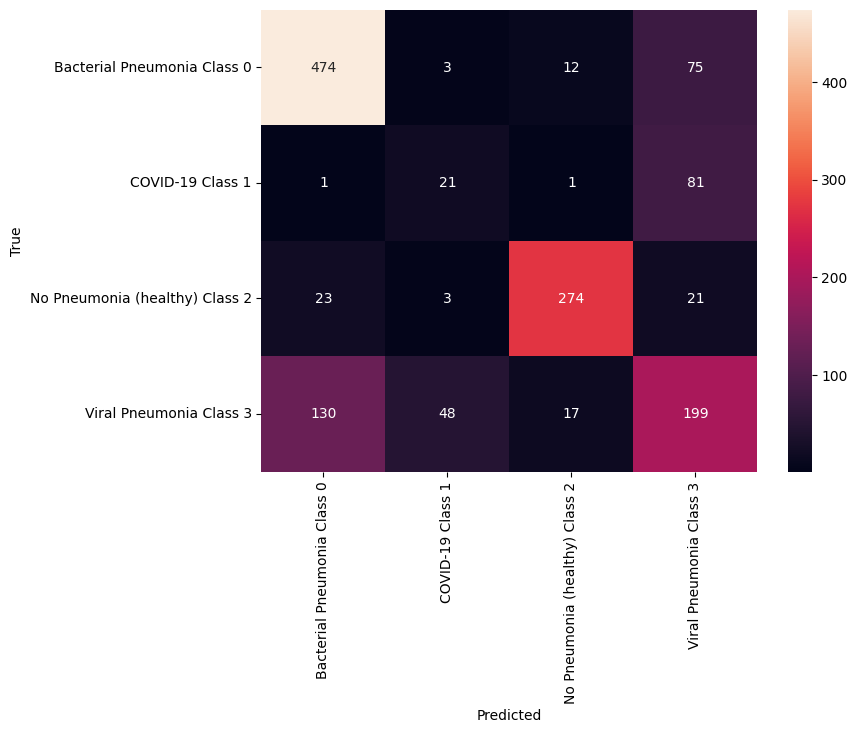

In [23]:
class_labels = ['Bacterial Pneumonia Class 0', 'COVID-19 Class 1', 'No Pneumonia (healthy) Class 2', 'Viral Pneumonia Class 3']

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Call the function to plot the confusion matrix with custom labels
plot_confusion_matrix(y_true_classes, y_pred_classes, y_test, class_labels)

Micro-averaged One-vs-Rest ROC AUC score:
0.90
Macro-averaged One-vs-Rest ROC AUC score:
0.86


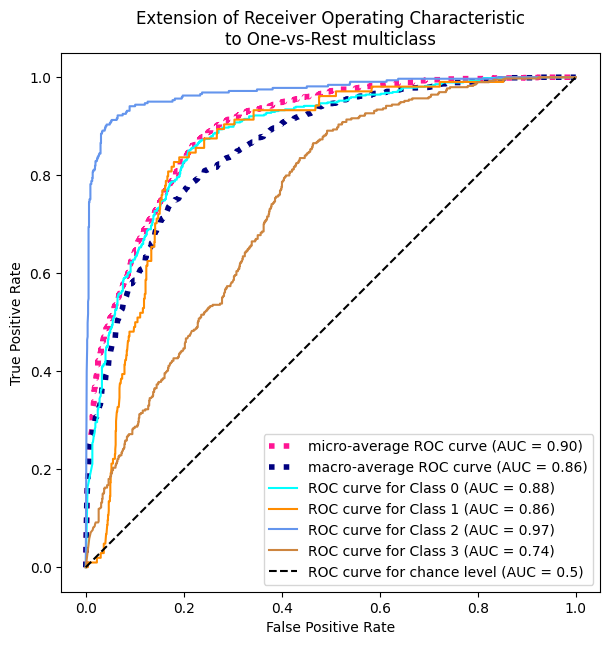

In [96]:
# Plot ROC/AUC curve
plot_roc_curves(y_test, y_pred, ['Class 0', 'Class 1', 'Class 2', 'Class 3'])

Interpretation
* The accuracy/loss plot illustrates improvements in both training and validation accuracy, with decreasing losses in the initial epochs. However, after the 6th epoch, a slight increase in validation loss indicates the primary issue with the model, suggesting overfitting. To mitigate this, potential measures involve employing regularization and normalization techniques, as well as architectural changes. Additionally, integrating early stopping and data augmentation could be helpful due to data imbalance and the small dataset size.
* The performance metrics may not necessarily indicate a strong performance of the base model, suggesting the model might struggle to capture the nuanced patterns within the data.
* Based on the ROC/AUC curve we see the model demonstrates strong performance in distinguishing certain classes (especially class 2) but may struggle a bit more with class 3 in comparison to the other classes.

## 5. Adapting/fine-tuning the network

In [10]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.keras import balanced_batch_generator

# The code is reused from the following repo: https://gist.github.com/arnaldog12/16efc663c869b35e2479bd607d56c1da 
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

Interpretation
* The dataset exhibits a noticeable imbalance among the four categories. Hence, the code above employs oversampling techniques on the minority groups, using augmented images to create a more balanced and expanded dataset for training the model.

In [20]:
# Create a function for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Implement data augmentation for the training data
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.12,
    height_shift_range=0.12,
)

# Initial learning rate
initial_lr = 0.001

balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=32)

steps_per_epoch = balanced_gen.steps_per_epoch

model_new = Sequential([
    Conv2D(35, (5, 5), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(50, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(65, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(90, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(130, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])


model_new.compile(optimizer=Adam(learning_rate=initial_lr),  # Adjust the learning rate as needed
              loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
              metrics=['accuracy'])  # Monitor accuracy during training


# Train the model with the learning rate scheduler, data augmentation, and early stopping
history_new = model_new.fit_generator(balanced_gen, steps_per_epoch, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_acc = model_new.evaluate(X_test, y_test)
print(test_acc)

Epoch 1/50


/var/folders/l7/rf0nbpkd00b4dh6cj_shvc2h0000gn/T/ipykernel_8115/3123424028.py:56: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_new = model_new.fit_generator(balanced_gen, steps_per_epoch, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])
2023-11-06 09:39:54.299920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.3479

2023-11-06 09:40:20.030975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 31s 215ms/step - loss: 1.3085 - accuracy: 0.3479 - val_loss: 1.1945 - val_accuracy: 0.3284
Epoch 2/50
140/140 [==============================] - 28s 199ms/step - loss: 0.9966 - accuracy: 0.5685 - val_loss: 0.9008 - val_accuracy: 0.5967
Epoch 3/50
140/140 [==============================] - 26s 186ms/step - loss: 0.7996 - accuracy: 0.6726 - val_loss: 0.8466 - val_accuracy: 0.6203
Epoch 4/50
140/140 [==============================] - 26s 186ms/step - loss: 0.7230 - accuracy: 0.7080 - val_loss: 0.7421 - val_accuracy: 0.6680
Epoch 5/50
140/140 [==============================] - 26s 185ms/step - loss: 0.6787 - accuracy: 0.7301 - val_loss: 0.6738 - val_accuracy: 0.7067
Epoch 6/50
140/140 [==============================] - 26s 185ms/step - loss: 0.6407 - accuracy: 0.7437 - val_loss: 0.6564 - val_accuracy: 0.7157
Epoch 7/50
140/140 [==============================] - 26s 185ms/step - loss: 0.6120 - accuracy: 0.7569 - val_loss: 0.6377 - val_accuracy: 0.7

In [113]:
y_pred = model_new.predict(X_test)

44/44 [==============================] - 2s 55ms/step


In [114]:
metrics(y_test, y_pred)

,F1-Score,Precision,Recall
Value,0.704374,0.697562,0.772714


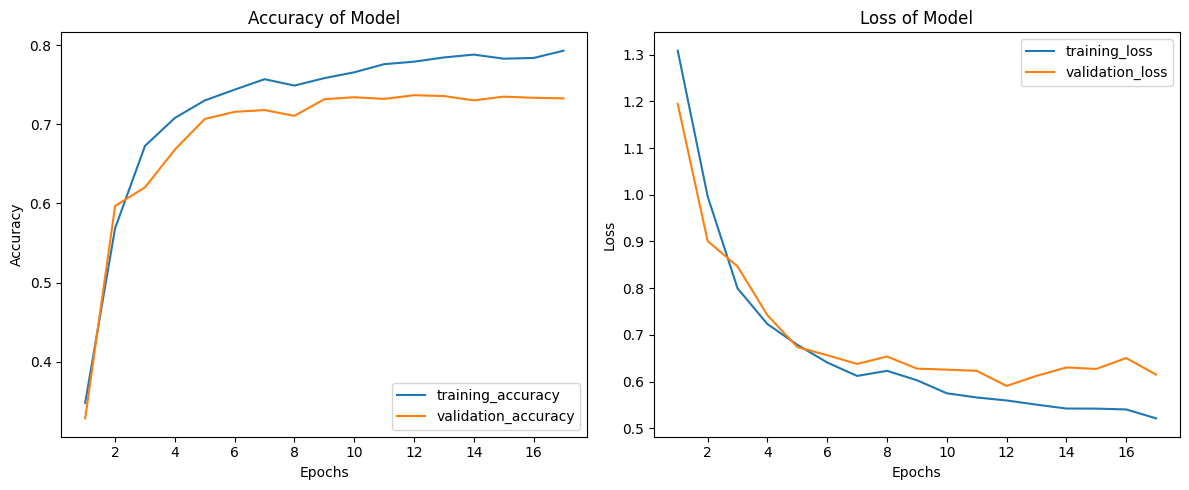

In [106]:
plot_training_history(history_new)

44/44 [==============================] - 3s 60ms/step


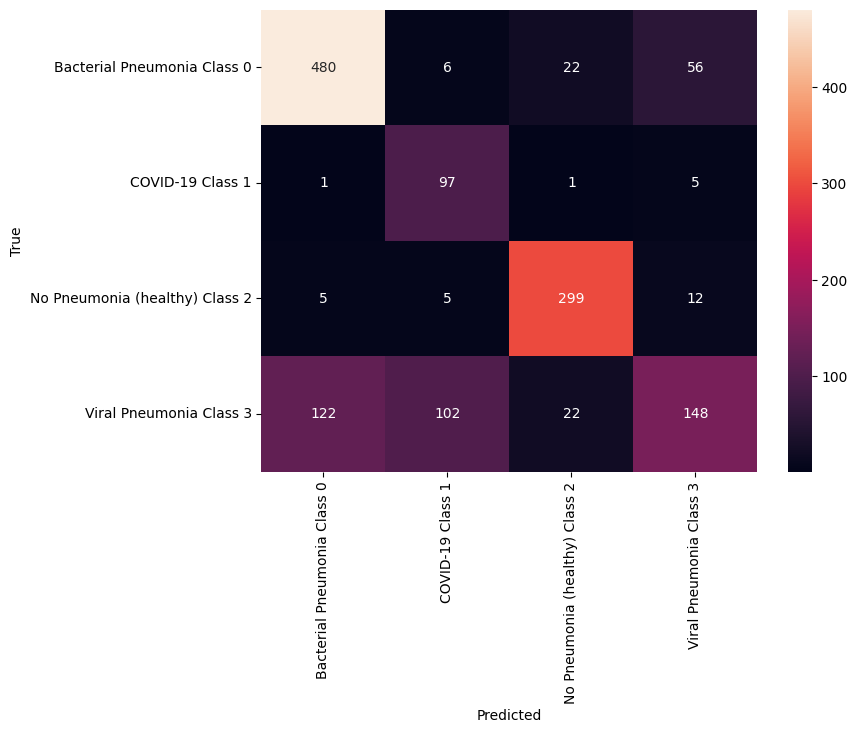

In [132]:
def plot_confusion_matrix(y_true, y_pred, y_test, class_labels):
    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

class_labels = ['Bacterial Pneumonia Class 0', 'COVID-19 Class 1', 'No Pneumonia (healthy) Class 2', 'Viral Pneumonia Class 3']

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Call the function to plot the confusion matrix with custom labels
plot_confusion_matrix(y_true_classes, y_pred_classes, y_test, class_labels)

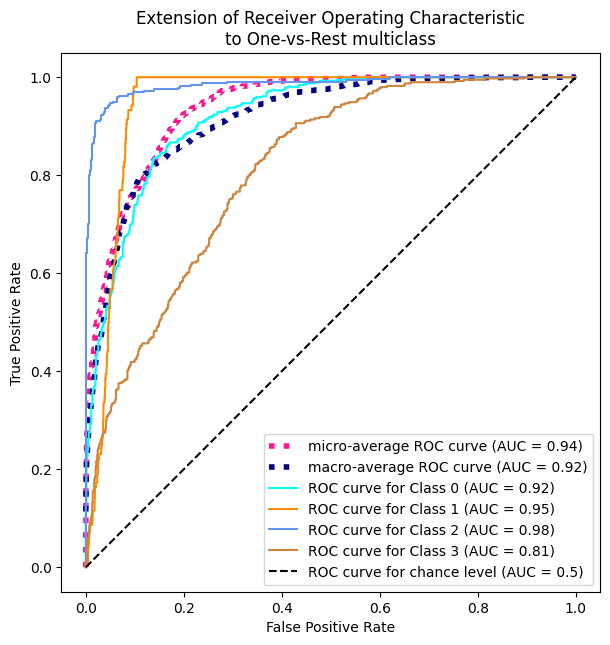

In [109]:
plot_roc_curves(y_test, y_pred, ['Class 0', 'Class 1', 'Class 2', 'Class 3'])

Interpretation
* The accuracy of the final evaluation on the test data improved to 0.7404 compared to 0.6999 in the previous model. The loss decreased to 0.5780 from 0.9536, signifying better model performance.
* All these metrics (F1-Score, Precision, and Recall) show considerable improvements.
* There's a notable improvement in the confusion matrix, especially in correctly identifying instances across all classes. The second model shows fewer misclassifications, with increased correct classifications across the board.
* Both micro-averaged and macro-averaged scores improved from 0.90 to 0.94 and 0.86 to 0.92, respectively. All individual class AUC scores also increased, especially for class 0, which went from 0.88 to 0.92, and class 1, which improved from 0.86 to 0.95. Class 2 maintained a high score of 0.98, while class 3 showed an increase from 0.74 to 0.81, though it still appears to be the class with the relatively weaker performance.

**Overall**, the second model, trained over more epochs, shows substantial enhancements in all performance metrics, with better accuracy, reduced loss, improved F1-Score, Precision, Recall, and higher AUC scores across all classes, indicating a more robust and accurate model.